In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-test/Book1.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


**Importing Libraries**

In [2]:
import numpy as np
import pandas as pd
 
#data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
 
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
 
#to avoid warnings
import warnings
warnings.filterwarnings('ignore')

**Loading Data Set**

In [3]:
train = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip") 
test = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip")
test_y = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip")

**Printing the Data**

In [4]:
print(train)
print(test)
print(test_y)

                      id                                       comment_text  \
0       0000997932d777bf  Explanation\nWhy the edits made under my usern...   
1       000103f0d9cfb60f  D'aww! He matches this background colour I'm s...   
2       000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3       0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
4       0001d958c54c6e35  You, sir, are my hero. Any chance you remember...   
...                  ...                                                ...   
159566  ffe987279560d7ff  ":::::And for the second time of asking, when ...   
159567  ffea4adeee384e90  You should be ashamed of yourself \n\nThat is ...   
159568  ffee36eab5c267c9  Spitzer \n\nUmm, theres no actual article for ...   
159569  fff125370e4aaaf3  And it looks like it was actually you who put ...   
159570  fff46fc426af1f9a  "\nAnd ... I really don't think you understand...   

        toxic  severe_toxic  obscene  threat  insul

In [5]:
print("Size of Train dataset:", train.shape)
print("Size of Test dataset:", test.shape)
print("Size of Test labels:", test_y.shape)

Size of Train dataset: (159571, 8)
Size of Test dataset: (153164, 2)
Size of Test labels: (153164, 7)


**Printing the First 6 Rows of Train Data**

In [6]:
train.head(6)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0


**Cleaning the Training Data by removing special characters punctuations etc**

In [7]:
import re
import string
# Removing special characters
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_n = lambda x: re.sub("\n", " ", x)
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)
train['comment_text'] = train['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

In [8]:
train_summary = train.describe().transpose()
test_summary = test.describe().transpose()
test_y_summary = test_y.describe().transpose()

print("Train Dataset Summary:")
print(train_summary)
print("\nTest Dataset Summary:")
print(test_summary)
print("\nTest Labels Summary:")
print(test_y_summary)

Train Dataset Summary:
                  count      mean       std  min  25%  50%  75%  max
toxic          159571.0  0.095844  0.294379  0.0  0.0  0.0  0.0  1.0
severe_toxic   159571.0  0.009996  0.099477  0.0  0.0  0.0  0.0  1.0
obscene        159571.0  0.052948  0.223931  0.0  0.0  0.0  0.0  1.0
threat         159571.0  0.002996  0.054650  0.0  0.0  0.0  0.0  1.0
insult         159571.0  0.049364  0.216627  0.0  0.0  0.0  0.0  1.0
identity_hate  159571.0  0.008805  0.093420  0.0  0.0  0.0  0.0  1.0

Test Dataset Summary:
               count  unique  \
id            153164  153164   
comment_text  153164  153164   

                                                            top freq  
id                                             ffffce3fb183ee80    1  
comment_text  " \n :::Stop already. Your bullshit is not wel...    1  

Test Labels Summary:
                  count      mean       std  min  25%  50%  75%  max
toxic          153164.0 -0.542530  0.572465 -1.0 -1.0 -1.0  0.0  1.0
s

**Cleaning Test Data by removing special characters punctuations etc**

In [9]:
import re
import string
# Removing special characters
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_n = lambda x: re.sub("\n", " ", x)
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)
test['comment_text'] = test['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

**Checking For Missing Values in The Data Set**

In [10]:
print("Check for missing values in Train dataset")
null_train = train.isnull().sum()
print(null_train)
print("Check for missing values in Test dataset")
null_test = test.isnull().sum()
print(null_test)
print("Check for missing values in Test_Y labels")
null_test_y = test_y.isnull().sum()
print(null_test_y)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
Check for missing values in Test_Y labels
id               0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


**Visualizing the class distribution of the 'label' columns**

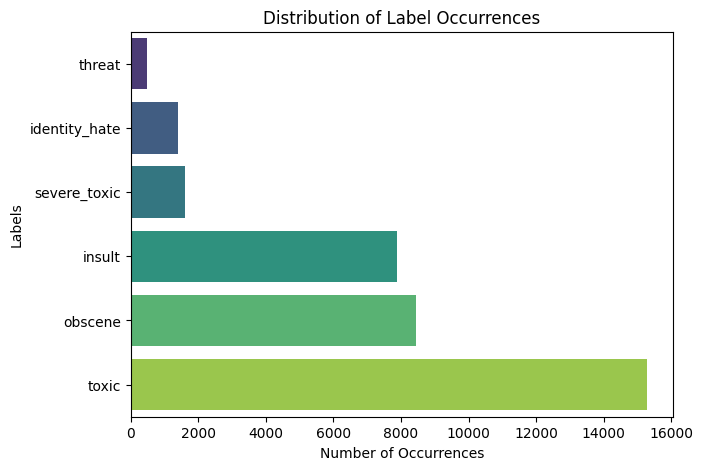

In [11]:
# Visualizing the class distribution of the 'label' column
column_labels = train.columns.tolist()[2:]
label_counts = train[column_labels].sum().sort_values()
 
 
# Create a black background for the plot
plt.figure(figsize=(7, 5))
 
# Create a horizontal bar plot using Seaborn
ax = sns.barplot(x=label_counts.values,
                 y=label_counts.index, palette='viridis')
 
 
# Add labels and title to the plot
plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')
 
# Show the plot
plt.show()

In [12]:
train[column_labels].sum().sort_values()

threat             478
identity_hate     1405
severe_toxic      1595
insult            7877
obscene           8449
toxic            15294
dtype: int64

**Checking How our Dataset is balanced**

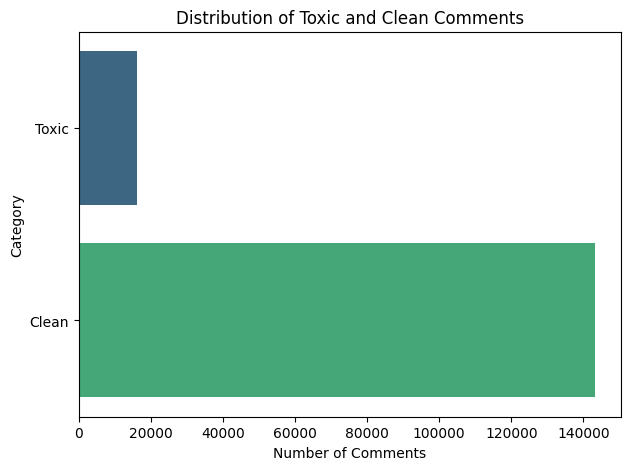

In [13]:
# Create subsets based on toxic and clean comments
train_toxic = train[train[column_labels].sum(axis=1) > 0]
train_clean = train[train[column_labels].sum(axis=1) == 0]
 
# Number of toxic and clean comments
num_toxic = len(train_toxic)
num_clean = len(train_clean)
 
# Create a DataFrame for visualization
plot_data = pd.DataFrame(
    {'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})
 
# Create a black background for the plot
plt.figure(figsize=(7, 5))
 
# Horizontal bar plot
ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis')
 
 
# Add labels and title to the plot
plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean Comments')
 
# Set ticks' color to white
ax.tick_params()
 
# Show the plot
plt.show()

In [14]:
print(train_toxic.shape)
print(train_clean.shape)

(16225, 8)
(143346, 8)


**Balancing the dataset by appling Random Sampling**

In [15]:
# Randomly sample 16,000 clean comments
train_clean_sampled = train_clean.sample(n=16225, random_state=42)
 
# Combine the toxic and sampled clean comments
df = pd.concat([train_toxic, train_clean_sampled], axis=0)

# Shuffle the data to avoid any order bias during training
dataframe = df.sample(frac=1, random_state=42)
dataframe.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
57737,9a8103881a1d8372,you are an old cougar you are an old cougar,1,0,0,0,1,0
46617,7c9a37dc040d6ef4,i m scared brrrr i m gonna die now,0,0,0,0,0,0
83356,df07677ce31a782d,okay so anal sex is as widely unaccepted and ...,1,0,0,0,0,0
34637,5c854590da41ac65,shut up you cunt wwwwwwwwwwwwwwwwwwwwwwwwwwwww...,1,0,1,0,1,0
27887,49cfe7691eb59201,you arrogant administrator homosexual bastards...,1,1,1,0,1,1


In [16]:
print(train_toxic.shape)
print(train_clean_sampled.shape)
print(dataframe.shape)

(16225, 8)
(16225, 8)
(32450, 8)


In [17]:
# Split data into training, testing sets & validation sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    dataframe['comment_text'], dataframe.iloc[:, 2:], test_size=0.25, random_state=42)

In [18]:
# validation set
test_texts, val_texts, test_labels, val_labels = train_test_split(
    test_texts, test_labels, test_size=0.5, random_state=42)

In [19]:
# Token and Encode Function
def tokenize_and_encode(tokenizer, comments, labels, max_length=128):
    # Initialize empty lists to store tokenized inputs and attention masks
    input_ids = []
    attention_masks = []
 
    # Iterate through each comment in the 'comments' list
    for comment in comments:
 
        # Tokenize and encode the comment using the BERT tokenizer
        encoded_dict = tokenizer.encode_plus(
            comment,
 
            # Add special tokens like [CLS] and [SEP]
            add_special_tokens=True,
 
            # Truncate or pad the comment to 'max_length'
            max_length=max_length,
 
            # Pad the comment to 'max_length' with zeros if needed
            pad_to_max_length=True,
 
            # Return attention mask to mask padded tokens
            return_attention_mask=True,
 
            # Return PyTorch tensors
            return_tensors='pt'
        )
 
        # Append the tokenized input and attention mask to their respective lists
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
 
    # Concatenate the tokenized inputs and attention masks into tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
 
    # Convert the labels to a PyTorch tensor with the data type float32
    labels = torch.tensor(labels, dtype=torch.float32)
 
    # Return the tokenized inputs, attention masks, and labels as PyTorch tensors
    return input_ids, attention_masks, labels

In [20]:
# Token Initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [21]:
# Model Initialization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=6)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# Move model to GPU if available
device = torch.device(
    'cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [23]:
# Tokenize and Encode the comments and labels for the training set
input_ids, attention_masks, labels = tokenize_and_encode(
    tokenizer,
    train_texts,
    train_labels.values
)
 
# Tokenize and Encode the comments and labels for the test set
test_input_ids, test_attention_masks, test_labels = tokenize_and_encode(
    tokenizer,
    test_texts,
    test_labels.values
)
 
# Tokenize and Encode the comments and labels for the validation set
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(
    tokenizer,
    val_texts,
    val_labels.values
)
 
 
print('Training Comments :',train_texts.shape)
print('Input Ids         :',input_ids.shape)
print('Attention Mask    :',attention_masks.shape)
print('Labels            :',labels.shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Training Comments : (24337,)
Input Ids         : torch.Size([24337, 128])
Attention Mask    : torch.Size([24337, 128])
Labels            : torch.Size([24337, 6])


In [24]:
k = 49
print('Training Comments -->>',train_texts.values[k])
print('\nInput Ids -->>\n',input_ids[k])
print('\nDecoded Ids -->>\n',tokenizer.decode(input_ids[k]))
print('\nAttention Mask -->>\n',attention_masks[k])
print('\nLabels -->>',labels[k])

Training Comments -->> blah  blah fuckin  blah  with   books  a time magazine article  several news articles and the presence of a number of celebrities  its notable  if you want a higher notability for it  do the research and add it yourself  you were just bored  feeling like  improving  some article by slapping a tag on it instead of actually improving it  and nobody would let you touch the jesus article  off with ye         

Input Ids -->>
 tensor([  101, 27984, 27984,  6616,  2378, 27984,  2007,  2808,  1037,  2051,
         2932,  3720,  2195,  2739,  4790,  1998,  1996,  3739,  1997,  1037,
         2193,  1997, 12330,  2049,  3862,  2065,  2017,  2215,  1037,  3020,
         2025,  8010,  2005,  2009,  2079,  1996,  2470,  1998,  5587,  2009,
         4426,  2017,  2020,  2074, 11471,  3110,  2066,  9229,  2070,  3720,
         2011, 22021,  1037,  6415,  2006,  2009,  2612,  1997,  2941,  9229,
         2009,  1998,  6343,  2052,  2292,  2017,  3543,  1996,  4441,  3720,
     

In [25]:
# Creating DataLoader for the balanced dataset
batch_size = 49
train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
 
# testing set 
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
 
# validation set 
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [26]:
 print('Batch Size :',train_loader.batch_size)
Batch =next(iter(train_loader))
print('Each Input ids shape :',Batch[0].shape)
print('Input ids :\n',Batch[0][0])
print('Corresponding Decoded text:\n',tokenizer.decode(Batch[0][0]))
print('Corresponding Attention Mask :\n',Batch[1][0])
print('Corresponding Label:',Batch[2][0])

Batch Size : 49
Each Input ids shape : torch.Size([49, 128])
Input ids :
 tensor([  101,  1045,  4872,  2025,  2000,  2886, 15453, 18150,  2102,  2004,
         1997,  2008,  2154,  6890,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     

In [27]:
# Optimizer setup
optimizer = AdamW(model.parameters(), lr=2e-5)

In [28]:
# Function to Train the Model
def train_model(model, train_loader, optimizer, device, num_epochs):
    # Loop through the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()
        # Initialize total loss for the current epoch
        total_loss = 0
 
        # Loop through the batches in the training data
        for batch in train_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]
 
            optimizer.zero_grad()
 
            outputs = model(
                input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
 
            loss.backward()
            optimizer.step()
 
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
 
        # Disable gradient computation during validation
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [
                    t.to(device) for t in batch]
 
                outputs = model(
                    input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()
        # Print the average loss for the current epoch
        print(
            f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)},Validation loss:{val_loss/len(val_loader)}')
 
 
# Call the function to train the model
train_model(model, train_loader, optimizer, device, num_epochs=3)

Epoch 1, Training Loss: 0.2218095417803442,Validation loss:0.15857046474534345
Epoch 2, Training Loss: 0.1455196589231491,Validation loss:0.14808486285338918
Epoch 3, Training Loss: 0.1226098472758438,Validation loss:0.14643808014421578


In [29]:
# Evaluate the Model
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
 
    true_labels = []
    predicted_probs = []
 
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]
 
            # Get model's predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            # Use sigmoid for multilabel classification
            predicted_probs_batch = torch.sigmoid(outputs.logits)
            predicted_probs.append(predicted_probs_batch.cpu().numpy())
 
            true_labels_batch = labels.cpu().numpy()
            true_labels.append(true_labels_batch)
 
    # Combine predictions and labels for evaluation
    true_labels = np.concatenate(true_labels, axis=0)
    predicted_probs = np.concatenate(predicted_probs, axis=0)
    predicted_labels = (predicted_probs > 0.5).astype(
        int)  # Apply threshold for binary classification
 
    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')
 
    # Print the evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
 
 
# Call the function to evaluate the model on the test data
evaluate_model(model, test_loader, device)

Accuracy: 0.7147
Precision: 0.8122
Recall: 0.8645


In [30]:
# Save the tokenizer and model in the same directory
output_dir = "Saved_model"
# Save model's state dictionary and configuration
model.save_pretrained(output_dir)
# Save tokenizer's configuration and vocabulary
tokenizer.save_pretrained(output_dir)

('Saved_model/tokenizer_config.json',
 'Saved_model/special_tokens_map.json',
 'Saved_model/vocab.txt',
 'Saved_model/added_tokens.json')

In [31]:
# Load the tokenizer and model from the saved directory
model_name = "Saved_model"
Bert_Tokenizer = BertTokenizer.from_pretrained(model_name)
Bert_Model = BertForSequenceClassification.from_pretrained(
    model_name).to(device)

In [32]:
def predict_user_input(input_text, model=Bert_Model, tokenizer=Bert_Tokenizer, device=device):
    user_input = [input_text]
 
    user_encodings = tokenizer(
        user_input, truncation=True, padding=True, return_tensors="pt")
 
    user_dataset = TensorDataset(
        user_encodings['input_ids'], user_encodings['attention_mask'])
 
    user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False)
 
    model.eval()
    with torch.no_grad():
        for batch in user_loader:
            input_ids, attention_mask = [t.to(device) for t in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.sigmoid(logits)
 
    predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int)
    labels_list = ['toxic', 'severe_toxic', 'obscene',
                   'threat', 'insult', 'identity_hate']
    result = dict(zip(labels_list, predicted_labels[0]))
    return result
 
 
text = 'Your a joker'
predict_user_input(input_text=text)

{'toxic': 1,
 'severe_toxic': 0,
 'obscene': 0,
 'threat': 0,
 'insult': 1,
 'identity_hate': 0}

In [33]:
def predict_user_input(input_text, model=Bert_Model, tokenizer=Bert_Tokenizer, device=device):
    user_input = [input_text]
 
    user_encodings = tokenizer(
        user_input, truncation=True, padding=True, return_tensors="pt")
 
    user_dataset = TensorDataset(
        user_encodings['input_ids'], user_encodings['attention_mask'])
 
    user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False)
 
    model.eval()
    with torch.no_grad():
        for batch in user_loader:
            input_ids, attention_mask = [t.to(device) for t in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.sigmoid(logits)
 
    predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int)
    labels_list = ['toxic', 'severe_toxic', 'obscene',
                   'threat', 'insult', 'identity_hate']
    result = dict(zip(labels_list, predicted_labels[0]))
    return result
 
 
def predict_user_input(test, model, tokenizer, device):
    MAX_LEN = 128
    input_ids = []
    attention_masks = []
    for text in test['comment_text'].head(5):
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=MAX_LEN,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'].squeeze())
        attention_masks.append(encoded['attention_mask'].squeeze())
    input_ids = torch.stack(input_ids).to(device)
    attention_masks = torch.stack(attention_masks).to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        predictions = torch.sigmoid(logits)
        predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int)
        labels_list = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        result = [dict(zip(labels_list, predicted_labels[i])) for i in range(len(predicted_labels))]
    return result

In [34]:
predictions = predict_user_input(test, Bert_Model, Bert_Tokenizer, device)
for i, prediction in enumerate(predictions):
    print(f"Row {i+1}:\n{prediction}\n")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Row 1:
{'toxic': 1, 'severe_toxic': 1, 'obscene': 1, 'threat': 0, 'insult': 1, 'identity_hate': 0}

Row 2:
{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}

Row 3:
{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}

Row 4:
{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}

Row 5:
{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}



In [35]:
val=pd.read_csv("/kaggle/input/new-test/Book1.csv")

In [36]:
val

,comment_text,clean
0,Your positivity is infectious!,1
1,You're doing a great job!,1
2,Your efforts don't go unnoticed.,1
3,You're always so kind.,1
4,Thank you for your help.,1
5,Your efforts don't go unnoticed.,1
6,You bring joy to those around you.,1
7,You're a valuable member of the team.,1
8,You're a valuable part of the team.,1
9,You're a good listener.,1


In [37]:
val['comment_text'] = val['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

In [38]:
val

,comment_text,clean
0,your positivity is infectious,1
1,you re doing a great job,1
2,your efforts don t go unnoticed,1
3,you re always so kind,1
4,thank you for your help,1
5,your efforts don t go unnoticed,1
6,you bring joy to those around you,1
7,you re a valuable member of the team,1
8,you re a valuable part of the team,1
9,you re a good listener,1


In [39]:
def predict_user_input(val, model, tokenizer, device):
    MAX_LEN = 128
    input_ids = []
    attention_masks = []
    for text in val['comment_text']:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=MAX_LEN,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'].squeeze())
        attention_masks.append(encoded['attention_mask'].squeeze())
    input_ids = torch.stack(input_ids).to(device)
    attention_masks = torch.stack(attention_masks).to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        predictions = torch.sigmoid(logits)
        predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int)
        labels_list = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        result = [dict(zip(labels_list, predicted_labels[i])) for i in range(len(predicted_labels))]
    return result

In [40]:
predictions = predict_user_input(val, Bert_Model, Bert_Tokenizer, device)
for i, prediction in enumerate(predictions):
    print(f"Row {i+1}:\n{prediction}\n")

Row 1:
{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}

Row 2:
{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}

Row 3:
{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}

Row 4:
{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}

Row 5:
{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}

Row 6:
{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}

Row 7:
{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}

Row 8:
{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}

Row 9:
{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}

Row 10:
{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}


In [41]:
import pandas as pd

# Assuming your predictions are stored in the variable 'predictions'
data = []
for i, prediction in enumerate(predictions):
    values = list(prediction.values())
    if sum(values) == 0:
        clean_value = 1
    else:
        clean_value = 0
    data.append({'clean': clean_value})

predict_subset = pd.DataFrame(data)
print(predict_subset)

    clean
0       1
1       1
2       1
3       1
4       1
5       1
6       1
7       1
8       1
9       1
10      1
11      1
12      1
13      1
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
30      0
31      0
32      0
33      0


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
Confusion Matrix:
[[20  0]
 [ 0 14]]


<Figure size 800x600 with 0 Axes>

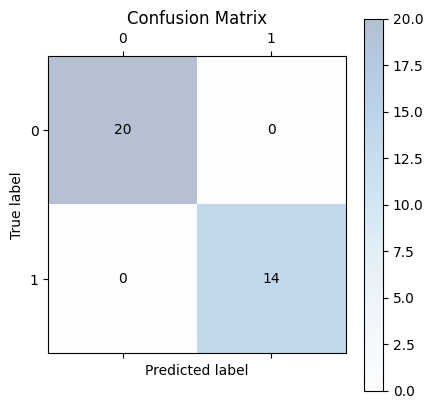

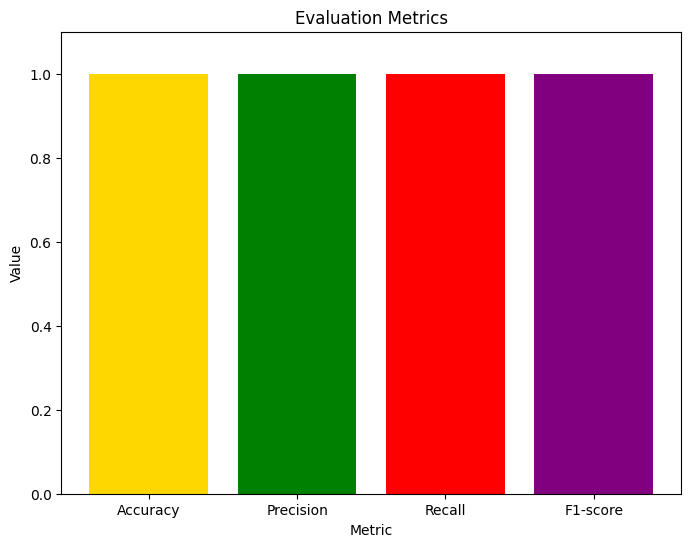

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate the metrics
y_true = val['clean']
y_pred = predict_subset

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, pos_label=1)
recall = recall_score(y_true, y_pred, pos_label=1)
f1 = f1_score(y_true, y_pred, pos_label=1)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print('Confusion Matrix:')
print(confusion_mat)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Add numbers to the confusion matrix
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        plt.text(j, i, confusion_mat[i, j], ha='center', va='center', color='black')

plt.show()

# Plot the evaluation metrics with different colors
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]
colors = ['gold', 'green', 'red', 'purple']  # Specify the colors here

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=colors)
plt.ylim([0, 1.1])
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Evaluation Metrics')
plt.show()